# 실행해야 하는 코드 위에 (★) 표시

# 0. 드라이브 마운트 (★)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. 초기 환경 설정

### 1-1. 라이브러리 설치, 임포트 (★)

In [2]:
!pip install datasets librosa matplotlib seaborn scikit-learn torch torchaudio torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 95.4 MB/s eta 0:00:00


In [3]:
import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_from_disk
import librosa
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

### 1-2. 중요 하이퍼파라미터 설정 (★)

In [4]:
SAMPLE_RATE = 22050
DURATION = 4 # 오디오 길이 통일 (4초)
N_MFCC = 40 # MFCC 개수
BATCH_SIZE = 32
EPOCHS = 50 # 학습 횟수
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 클래스 이름 정의 (UrbanSound8K 10개 클래스)
classes = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark",
    "drilling", "engine_idling", "gun_shot", "jackhammer",
    "siren", "street_music"
]

print(f"Using device: {device}")

Using device: cuda


# 2. 오디오 데이터 불러오기

### 훈련용 데이터셋이므로, 평가 시에는 실행 불필요.

In [ ]:
print("Loading UrbanSound8K Dataset...")
dataset = load_dataset("danavery/urbansound8K", split="train")

## 2-1. 오디오 데이터셋 전처리 함수 (★)

In [5]:
class AudioDataset(Dataset):
    def __init__(self, data_list):
        self.data = data_list

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]

        # 오디오 처리
        audio_info = item['audio']
        audio = audio_info['array']
        sr = audio_info['sampling_rate']
        label = item['classID']

        # 전처리
        if sr != SAMPLE_RATE:
            audio = librosa.resample(audio, orig_sr=sr, target_sr=SAMPLE_RATE)

        # 오디오 길이 고정
        max_len = SAMPLE_RATE * DURATION
        if len(audio) < max_len:
            pad_width = max_len - len(audio)
            audio = np.pad(audio, (0, pad_width), mode='constant')
        else:
            audio = audio[:max_len]

        mfcc = librosa.feature.mfcc(y=audio, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
        mfcc = librosa.power_to_db(mfcc)

        # 텐서 변환 (Channel, Height, Width) -> (1, n_mfcc, time_steps)
        return torch.tensor(mfcc, dtype=torch.float32).unsqueeze(0), torch.tensor(label, dtype=torch.long)

## 2-2. 학습 데이터셋 분할 및 전처리 - 평가 시에는 불필요

In [ ]:
full_data_list = list(dataset)
train_data, test_data = train_test_split(full_data_list, test_size=0.2, random_state=42, stratify=[x['classID'] for x in full_data_list])

train_dataset = AudioDataset(train_data)
test_dataset = AudioDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Train samples: {len(train_dataset)}, Test samples: {len(test_dataset)}")

Train samples: 6985, Test samples: 1747


# 3. 모델 정의 - Residual Block + CNN 기반 오디오 분류 모델 (★)

In [6]:
# A. Squeeze-and-Excitation (SE) Block 정의
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        # 1. Squeeze: Global Average Pooling을 통해 채널 정보를 압축
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        # 2. Excitation: 두 개의 FC Layer로 채널별 중요도를 학습
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid() # Sigmoid를 통해 0과 1 사이의 가중치 생성
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        # Squeeze
        y = self.avg_pool(x).view(b, c)
        # Excitation
        y = self.fc(y).view(b, c, 1, 1)
        # Re-weighting: 입력 특징 맵에 가중치(y)를 곱함
        return x * y.expand_as(x)

# B. Residual Block 정의 (Conv + BN + ReLU + SE)
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_se=True):
        super(ResidualBlock, self).__init__()

        # 잔차 연결을 위한 Conv (입력 채널과 출력 채널이 다를 경우 사용)
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

        # 주 경로 1
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # 주 경로 2
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        # SE Block 추가
        self.se_block = SEBlock(out_channels) if use_se else None

    def forward(self, x):
        # 숏컷 경로 (Shortcut/Residual path)
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        # 주 경로 (Main path)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        # SE Attention 적용
        if self.se_block is not None:
            out = self.se_block(out)

        # 잔차 연결: Main path + Shortcut path
        out += identity
        out = self.relu(out)
        return out

# C. 최종 ResSEAudioCNN 모델 구조
class ResSEAudioCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(ResSEAudioCNN, self).__init__()

        # 초기 입력 처리
        self.initial_layer = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # 잔차 블록 섹션
        # ResNet 스타일로 블록 쌓기
        self.layer1 = self._make_layer(32, 64, num_blocks=2, stride=2)
        self.layer2 = self._make_layer(64, 128, num_blocks=2, stride=2)
        self.layer3 = self._make_layer(128, 256, num_blocks=2, stride=2)

        # Global Average Pooling (출력 채널: 256)
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        # Classifier (드롭아웃은 Residual Block 내부에서 처리되어 최종 분류기는 단순화)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, num_classes)
        )

    def _make_layer(self, in_channels, out_channels, num_blocks, stride):
        layers = []
        # 첫 번째 블록에서만 스트라이드(Stride)를 적용하여 다운샘플링
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride))
        # 나머지 블록은 스트라이드 1로 채널 수 유지
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels, stride=1))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.initial_layer(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.global_pool(x)
        x = self.classifier(x)

        return x

### 학습을 위한 실행 코드이므로, 평가 시 실행 불필요.

In [ ]:
model = ResSEAudioCNN(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 4. 학습 - 평가 시 실행 불필요.

In [ ]:
print("Training Start...")

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, Acc: {100 * correct / total:.2f}%")

print("Training Finished.")

# 5. 모델 저장 - 평가 시 실행 불필요.

In [ ]:
# 파일명 정의
MODEL_PATH = "drive/MyDrive/audio_cnn_model_train.pth"

# 모델의 가중치만 저장
# model.state_dict()는 모델의 학습 가능한 파라미터(가중치와 편향)를 담고 있습니다.
torch.save(model.state_dict(), MODEL_PATH)

print(f"Model weights saved successfully to {MODEL_PATH}")

# 6. 저장된 모델 불러오기 (★)

In [7]:
# 1. 모델 클래스 정의
model = ResSEAudioCNN(num_classes=10).to(device)

# 2. 저장된 상태 사전(state_dict) 로드
MODEL_PATH = "drive/MyDrive/audio_cnn_model.pth"
loaded_state_dict = torch.load(MODEL_PATH, weights_only=True, map_location=device) # 저장 시와 다른 장치(CPU/GPU)에서 로드할 경우 map_location 지정

# 3. 모델 객체에 상태 사전 적용
model.load_state_dict(loaded_state_dict)

# 4. 모델을 평가 모드로 전환
model.eval()

print(f"Model loaded successfully from {MODEL_PATH} and ready for inference.")

Model loaded successfully from drive/MyDrive/audio_cnn_model.pth and ready for inference.


# 7. 추론 및 혼동행렬 생성 파이프라인 (★)

In [8]:
def evaluate_and_plot_cm(model, loader, device, class_names):
    y_pred = []
    y_true = []

    # 1. 예측 수행
    model.eval()  # 평가 모드
    print("Evaluating model on Test Set...")

    with torch.no_grad():
        # tqdm을 사용하여 진행 상황바 표시
        for inputs, labels in tqdm(loader, desc="Inference"):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            # CPU로 이동 후 리스트에 저장
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

    # 2. 혼동행렬 계산
    cm = confusion_matrix(y_true, y_pred)

    # 3. 시각화 (Heatmap)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names,
                yticklabels=class_names)

    plt.xlabel('Predicted Label', fontsize=12, fontweight='bold')
    plt.ylabel('True Label', fontsize=12, fontweight='bold')
    plt.title('UrbanSound8K Confusion Matrix', fontsize=15)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # 4. 클래스별 정확도 출력
    # 대각선 값(정답) / 해당 클래스의 총 개수(행의 합)
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    print("\n" + "="*30)
    print("Class-wise Accuracy")
    print("="*30)
    for i, acc in enumerate(class_accuracy):
        print(f"{class_names[i]:<20}: {acc*100:.2f}%")
    print("="*30)

### 훈련 시 결과 확인을 위해 활용한 코드이므로, 실행 불필요.

In [ ]:
evaluate_and_plot_cm(model, test_loader, device, classes)

# 8. Test 데이터(평가) (★)

## 8-1. 테스트 데이터 전처리 (★)
##### (i) 가정 1. 테스트 데이터 역시, 훈련 데이터처럼 dataset 형태로 가져온다고 가정!
##### (i) 가정 2. 테스트 데이터 역시, 훈련 데이터처럼 'audio' 컬럼(array + sampling_rate)의 데이터와, 'classID' 컬럼의 정답 데이터가 존재한다고 가정!
##### (i) 가정 3. 테스트 데이터 역시, 훈련 데이터처럼 다음과 같은 클래스 이름과 'classID' 컬럼의 숫자가 순서대로 0부터 9까지 대응된다고 가정!
>> classes = [
    "air_conditioner", "car_horn", "children_playing", "dog_bark",
    "drilling", "engine_idling", "gun_shot", "jackhammer",
    "siren", "street_music"
]

In [11]:
# 1. dataset 형태로 데이터 가져오기 ######################################
# dataset = load_dataset("danavery/urbansound8K", split="train")  # 테스트 시에 예시 데이터 전체로 테스트 진행.
dataset = load_dataset("test_data") # 테스트로 사용할 데이터 로드
##########################################################################

# 2. dataset list 형태로 변환하기
dataset_list = list(dataset)

# 3. 데이터셋 전처리
test_data = AudioDataset(dataset_list)

# 4. data loader
loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00016-e478d7cccca6a0(…):   0%|          | 0.00/434M [00:00<?, ?B/s]

data/train-00001-of-00016-299138aa39afaa(…):   0%|          | 0.00/472M [00:00<?, ?B/s]

data/train-00002-of-00016-887e0748205b6f(…):   0%|          | 0.00/384M [00:00<?, ?B/s]

data/train-00003-of-00016-691ee48aa53d9c(…):   0%|          | 0.00/447M [00:00<?, ?B/s]

data/train-00004-of-00016-c0f37514d8e28a(…):   0%|          | 0.00/441M [00:00<?, ?B/s]

data/train-00005-of-00016-55ef1a0a51149c(…):   0%|          | 0.00/591M [00:00<?, ?B/s]

data/train-00006-of-00016-0ef363072505e6(…):   0%|          | 0.00/496M [00:00<?, ?B/s]

data/train-00007-of-00016-dfac173beb21e5(…):   0%|          | 0.00/588M [00:00<?, ?B/s]

data/train-00008-of-00016-2744487f32f65d(…):   0%|          | 0.00/493M [00:00<?, ?B/s]

data/train-00009-of-00016-83fc7364d47981(…):   0%|          | 0.00/549M [00:00<?, ?B/s]

data/train-00010-of-00016-4c1d0e285ed778(…):   0%|          | 0.00/353M [00:00<?, ?B/s]

data/train-00011-of-00016-79d186503a2667(…):   0%|          | 0.00/316M [00:00<?, ?B/s]

data/train-00012-of-00016-6aff88fdcca229(…):   0%|          | 0.00/372M [00:00<?, ?B/s]

data/train-00013-of-00016-17d827b1a5be04(…):   0%|          | 0.00/348M [00:00<?, ?B/s]

data/train-00014-of-00016-c630762df85f6c(…):   0%|          | 0.00/381M [00:00<?, ?B/s]

data/train-00015-of-00016-03506887d89adf(…):   0%|          | 0.00/335M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/8732 [00:00<?, ? examples/s]

##### 혼동 매트릭스 출력 (★)

Evaluating model on Test Set...


Inference: 100%|██████████| 273/273 [03:12<00:00,  1.42it/s]


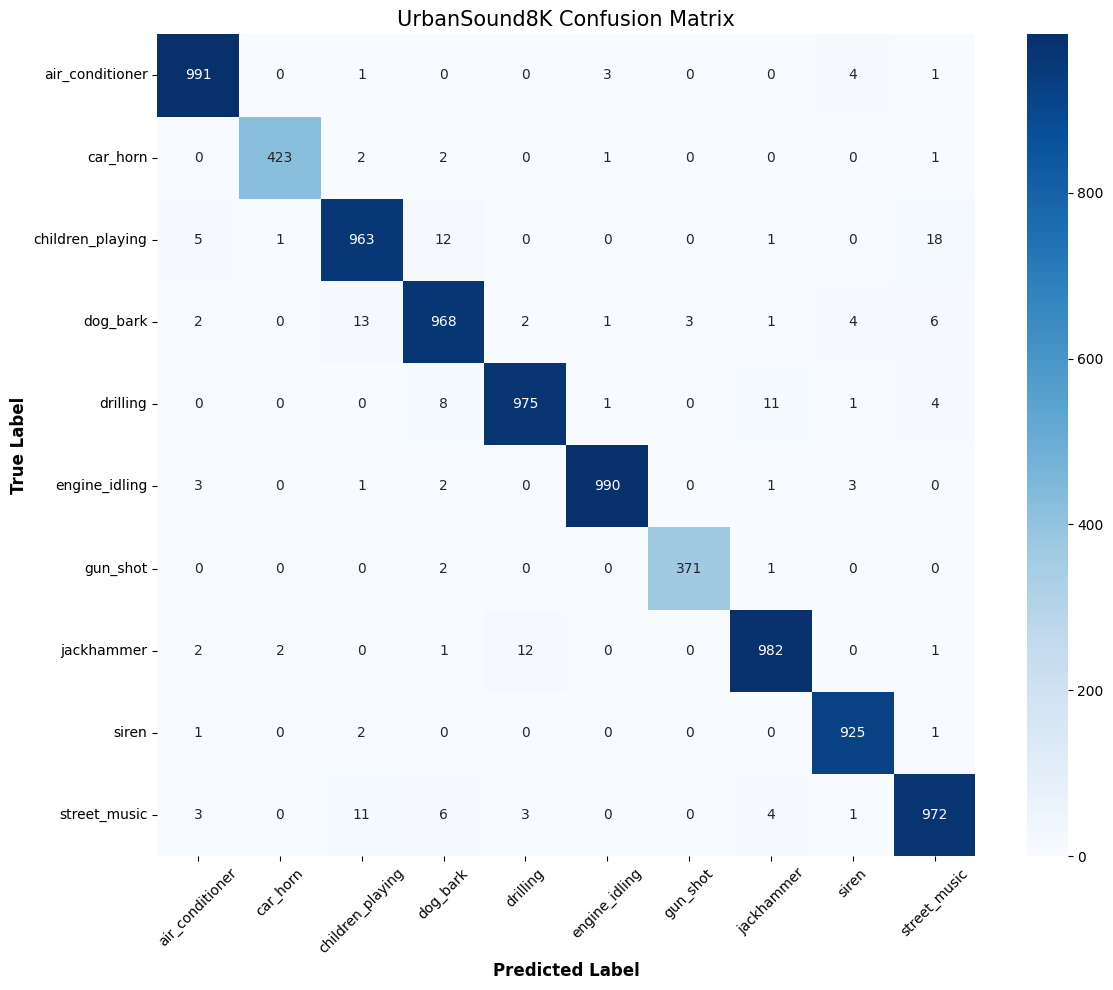


Class-wise Accuracy
air_conditioner     : 99.10%
car_horn            : 98.60%
children_playing    : 96.30%
dog_bark            : 96.80%
drilling            : 97.50%
engine_idling       : 99.00%
gun_shot            : 99.20%
jackhammer          : 98.20%
siren               : 99.57%
street_music        : 97.20%


In [13]:
# 모델 추론 및 혼동 매트릭스 출력
evaluate_and_plot_cm(model, loader, device, classes)